In [1]:
from pathlib import Path
from typing import Callable, Optional
from dataclasses import dataclass

from opt_sim_dataset import OptSimilaritiesDataset

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

In [2]:
data = OptSimilaritiesDataset(Path('./data'), 24, 100, 1)

In [3]:
def test_dataset(data: OptSimilaritiesDataset):
    X, Y, blocks = [], [], []
    first_sample_len = len(list(Path('./data/block0/0').iterdir())) 
    for idx in range(first_sample_len + 1):
        x, y, block = data[idx] 
        X.append(x)
        Y.append(y)
        blocks.append(block)

    x0 = torch.load('./data/block0/0/0.pt')
    assert torch.allclose(x0, X[0]), 'Wrong x values'
    assert blocks[0] == 0, 'Wrong block value'

    x1 = torch.load('./data/block0/0/1.pt')
    assert torch.allclose(x1, X[1]), 'Wrong x values'
    assert blocks[1] == 0, 'Wrong block value'

    x2 = torch.load('./data/block0/1/0.pt')
    assert torch.allclose(x2, X[first_sample_len]), 'Wrong x values'
    assert blocks[first_sample_len] == 0, 'Wrong block values'

    y0 = F.cosine_similarity(
        torch.load('./data/block1/0/0.pt'),
        torch.load(f'./data/block{data.n + 1}/0/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[0], y0), 'Wrong y values'

    y1 = F.cosine_similarity(
        torch.load('./data/block1/0/1.pt'),
        torch.load(f'./data/block{data.n + 1}/0/1.pt'),
        dim=-1
    )
    assert torch.isclose(Y[1], y1), 'Wrong y values'

    y2 = F.cosine_similarity(
        torch.load('./data/block1/1/0.pt'),
        torch.load(f'./data/block{data.n + 1}/1/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[first_sample_len], y2), 'Wrong y values'

test_dataset(data)
print('All tests passed')

All tests passed


In [113]:
@dataclass 
class MlpConfig:
    input_size: int
    output_size: int
    hidden_size: Optional[int] 

class LogReg(nn.Module):
    def __init__(self, config: MlpConfig):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(config.input_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        return self.sigmoid(self.fc(x))

class SimpleMLP(nn.Module):
    def __init__(self, config: MlpConfig):
        super(SimpleMLP, self).__init__()
        assert config.hidden_size is not None 

        self.fc1 = nn.Linear(config.input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.hidden_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        # ignore args just to be compatible with PerBlockMlp
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

class PerBlockNet(nn.Module):
    def __init__(self, num_blocks: int, config: MlpConfig, block_net_cls: Callable[[MlpConfig], nn.Module]):
        super(PerBlockNet, self).__init__()
        self.num_blocks = num_blocks
        self.mlps = nn.ModuleList([block_net_cls(config) for _ in range(num_blocks)])
    
    def forward(self, x, blocks):
        out = torch.zeros(x.size(0))
        for idx, (xi, block) in enumerate(zip(x, blocks)):
            out[idx] = self.mlps[block](xi)
        
        return out.view(-1, 1) 

In [106]:
@torch.no_grad
def measure_loss(model, criterion, loader, device):
    model.eval()
    epoch_loss = 0
    for inputs, labels, blocks in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs, blocks).to(device)
        loss = criterion(outputs, labels)

        batch_size = outputs.numel()
        epoch_loss += loss.item() * batch_size / len(loader.dataset)

    return epoch_loss

In [2]:
x = torch.randn((768, 1)).to('cuda')
M = torch.randn((768, 768)).to('cuda')
(M @ x).shape

torch.Size([768, 1])

In [3]:
%timeit M @ x 

24.1 µs ± 488 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
%timeit x.T @ M

16.6 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
x[::2] = 0
%timeit x.T @ M

16.5 µs ± 773 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
def train_mlp(train_loader: DataLoader, val_loader: DataLoader, 
              model: SimpleMLP, criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
              num_epochs: int, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()  
        epoch_loss = 0
        for inputs, labels, blocks in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            blocks = blocks.to(device)

            outputs = model(inputs, blocks).to(device)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = outputs.numel()
            epoch_loss += loss.item() * batch_size / len(train_loader.dataset)

        print(f'Epoch {epoch}: train_loss={epoch_loss:.4e}, val_loss={measure_loss(model, criterion, val_loader, device):.4e}') 
    
    return model

In [107]:
N = len(data)
test_len = int(N * 0.3)
train_and_val_data, test_data = random_split(data, [N - test_len, test_len])

batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

config = MlpConfig(
    input_size=2048,
    hidden_size=256,
    output_size=1
)

In [112]:
for train_ratio in [0.6]: # torch.linspace(0.1, 0.6, 6):
    train_len = int(N * train_ratio)
    train_data, val_data = random_split(train_and_val_data, [train_len, N - train_len - test_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    device = 'cuda'
    model = PerBlockNet(data.per_sample_len, config, SimpleMLP) 
    criterion = nn.MSELoss() 
    model = train_mlp(train_loader, val_loader, model, criterion, 4, device)

    print(f'{train_ratio=}, test loss = {measure_loss(model, criterion, test_loader, device):.4e}')

TypeError: super(type, obj): obj must be an instance or subtype of type

In [65]:
per_block = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block[block].append(out.item())

In [66]:
for idx, x in enumerate(per_block):
    print(idx, len(x))

0 282
1 265
2 301
3 296
4 285
5 270
6 286
7 267
8 274
9 324
10 265
11 278
12 321
13 296
14 270
15 289
16 283
17 278
18 309
19 305
20 270
21 289


In [73]:
batch = next(iter(test_loader))

In [76]:
model(batch[0].to(device), batch[2])

tensor([[0.9835],
        [0.9916],
        [1.0000],
        [0.9613],
        [1.0000],
        [0.9756],
        [0.9968],
        [0.9414],
        [1.0000],
        [0.9928],
        [0.9851],
        [1.0000],
        [0.9888],
        [0.9937],
        [0.9900],
        [0.9891]], grad_fn=<ViewBackward0>)

In [75]:
model.mlps[21](batch[0])

tensor([[1.0000],
        [0.9735],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9953],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9981],
        [0.9967],
        [0.9997]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [74]:
model.mlps[23](batch[0])

tensor([[0.4870],
        [0.4882],
        [0.5312],
        [0.4597],
        [0.4801],
        [0.4932],
        [0.4982],
        [0.5077],
        [0.4125],
        [0.5044],
        [0.5208],
        [0.4341],
        [0.4851],
        [0.4895],
        [0.4962],
        [0.4915]], device='cuda:0', grad_fn=<SigmoidBackward0>)

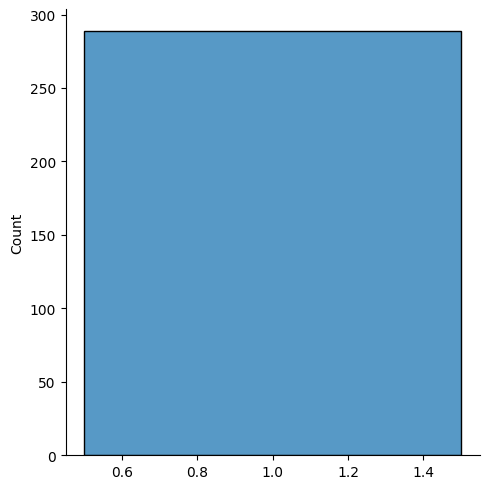

In [68]:
import seaborn as sns

sns.displot(per_block[-1])

In [16]:
simple_model = SimpleMLP(2048, 64, 1).to(device)
train_mlp(train_loader, val_loader, simple_model, criterion, 4, device)
measure_loss(simple_model, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=3.4653e-03, val_loss=1.3404e-03
Epoch 1: train_loss=1.2936e-03, val_loss=1.3022e-03
Epoch 2: train_loss=1.2833e-03, val_loss=1.2993e-03
Epoch 3: train_loss=1.2810e-03, val_loss=1.2974e-03


0.0012980955183389572

In [17]:
per_block_simple = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in train_loader:
    inputs = inputs.to(device)
    outputs = simple_model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block_simple[block].append(out.item())

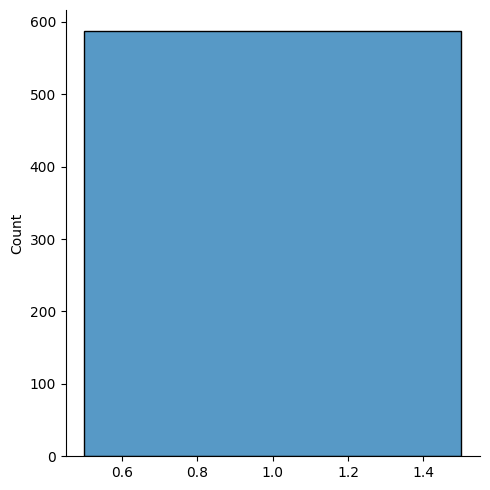

In [42]:
sns.displot(per_block_simple[20])

In [19]:
per_block_actual = [[] for _ in range(data.per_sample_len)]
for _, y, blocks in train_loader:
    for block, sim in zip(blocks, y):
        per_block_actual[block].append(sim.item())

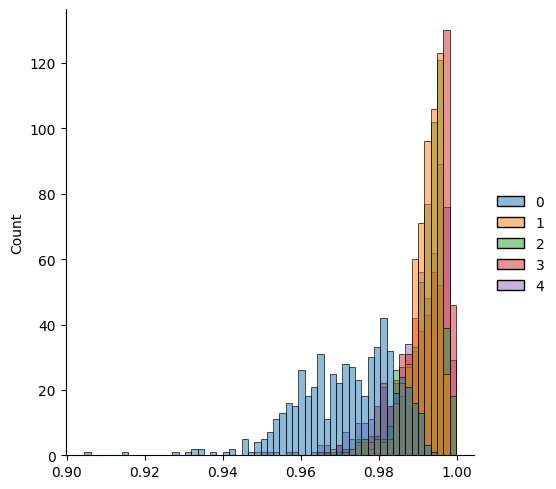

In [132]:
sns.displot(per_block_actual[:5]) 

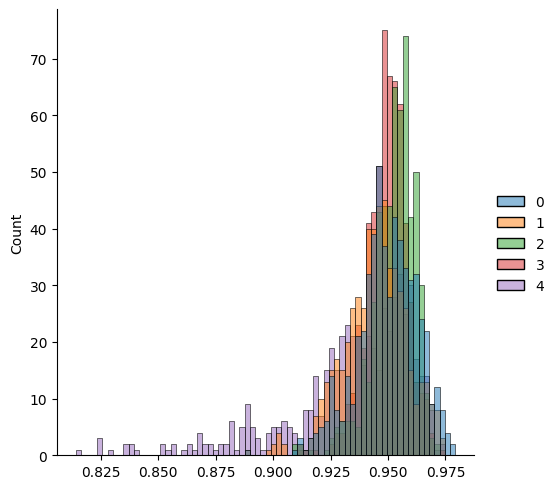

In [133]:
sns.displot(per_block_actual[-5:])

In [30]:
sims = torch.tensor(per_block_actual[0])

In [31]:
sims.mean()

tensor(0.9717)

In [32]:
sims.quantile(0.05)

tensor(0.9519)

In [37]:
for idx, x in enumerate(per_block_actual):
    print(idx, torch.tensor([x]).mean())

0 tensor(0.9717)
1 tensor(0.9914)
2 tensor(0.9918)
3 tensor(0.9915)
4 tensor(0.9900)
5 tensor(0.9880)
6 tensor(0.9829)
7 tensor(0.9805)
8 tensor(0.9766)
9 tensor(0.9745)
10 tensor(0.9729)
11 tensor(0.9721)
12 tensor(0.9726)
13 tensor(0.9659)
14 tensor(0.9584)
15 tensor(0.9601)
16 tensor(0.9610)
17 tensor(0.9494)
18 tensor(0.9440)
19 tensor(0.9524)
20 tensor(0.9493)
21 tensor(0.9336)


In [114]:
logreg = LogReg(config).to(device)
train_mlp(train_loader, val_loader, logreg, criterion, 4, device)
measure_loss(logreg, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=1.2442e-02, val_loss=4.8880e-03
Epoch 1: train_loss=4.6387e-03, val_loss=2.9742e-03
Epoch 2: train_loss=2.8655e-03, val_loss=2.1158e-03
Epoch 3: train_loss=2.0515e-03, val_loss=1.6955e-03


0.001778317593724716

In [116]:
logreg_better = PerBlockNet(data.per_sample_len, config, LogReg).to(device)
train_mlp(train_loader, val_loader, logreg_better, criterion, 4, device)
measure_loss(logreg_better, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=1.2326e-02, val_loss=3.1574e-03
Epoch 1: train_loss=2.5728e-03, val_loss=1.6767e-03
Epoch 2: train_loss=1.3673e-03, val_loss=1.1126e-03
Epoch 3: train_loss=9.4583e-04, val_loss=9.2853e-04


0.0009318764228455033

In [117]:
measure_loss(model, criterion, test_loader, device)

0.0010711639471741882

In [118]:
features = torch.randn((768, 768))
true_A = torch.randn((768, 768))
outputs = true_A @ features
# (X^T X)^(-1) X^T y
approx_a = torch.linalg.inv(features.T @ features) @ features.T @ outputs 